In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
PROJECT = Path("C:/Users/Admin/Desktop/Projects/turbofan-health-explorer")
PROC = PROJECT / "data" / "processed"
REPORTS = PROJECT / "reports"
REPORTS.mkdir(exist_ok=True)

# Load engineered dataset
df = pd.read_parquet(PROC / "train_FD001_features.parquet")

print("Loaded:", df.shape)
df.head()


Loaded: (20631, 22)


,unit,cycle,op1,op2,op3,s2,s3,s4,s7,s8,...,s3_rollmean,s3_rollstd,s4_rollmean,s4_rollstd,s2_ema,s3_ema,s4_ema,s2_slope,s3_slope,s4_slope
0,1,1,-0.0007,-0.0004,100.0,641.820007,1589.699951,1400.599976,554.359985,2388.060059,...,1589.699951,0.000000,1400.599976,0.000000,641.820007,1589.699951,1400.599976,NaN,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,642.150024,1591.819946,1403.140015,553.750000,2388.040039,...,1590.759949,1.499063,1401.869995,1.796079,641.851438,1589.901855,1400.841884,0.330017,2.119995,2.540039
2,1,3,-0.0043,0.0003,100.0,642.349976,1587.989990,1404.199951,554.260010,2388.080078,...,1589.836629,1.918633,1402.646647,1.850004,641.898917,1589.719773,1401.161700,0.264984,-0.854980,1.799988
3,1,4,0.0007,0.0000,100.0,642.349976,1582.790039,1401.869995,554.450012,2388.110107,...,1588.074982,3.855867,1402.452484,1.559639,641.941875,1589.059798,1401.229157,0.178986,-2.455969,0.487000
4,1,5,-0.0019,-0.0002,100.0,642.369995,1582.849976,1406.219971,554.000000,2388.060059,...,1587.029980,4.075650,1403.205981,2.159432,641.982649,1588.468387,1401.704472,0.129993,-2.272986,0.996997


In [2]:
# Compute RUL per unit
df["max_cycle"] = df.groupby("unit")["cycle"].transform("max")
df["RUL"] = df["max_cycle"] - df["cycle"]

# Drop helper
df = df.drop(columns=["max_cycle"])

df.head()


,unit,cycle,op1,op2,op3,s2,s3,s4,s7,s8,...,s3_rollstd,s4_rollmean,s4_rollstd,s2_ema,s3_ema,s4_ema,s2_slope,s3_slope,s4_slope,RUL
0,1,1,-0.0007,-0.0004,100.0,641.820007,1589.699951,1400.599976,554.359985,2388.060059,...,0.000000,1400.599976,0.000000,641.820007,1589.699951,1400.599976,NaN,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,642.150024,1591.819946,1403.140015,553.750000,2388.040039,...,1.499063,1401.869995,1.796079,641.851438,1589.901855,1400.841884,0.330017,2.119995,2.540039,190
2,1,3,-0.0043,0.0003,100.0,642.349976,1587.989990,1404.199951,554.260010,2388.080078,...,1.918633,1402.646647,1.850004,641.898917,1589.719773,1401.161700,0.264984,-0.854980,1.799988,189
3,1,4,0.0007,0.0000,100.0,642.349976,1582.790039,1401.869995,554.450012,2388.110107,...,3.855867,1402.452484,1.559639,641.941875,1589.059798,1401.229157,0.178986,-2.455969,0.487000,188
4,1,5,-0.0019,-0.0002,100.0,642.369995,1582.849976,1406.219971,554.000000,2388.060059,...,4.075650,1403.205981,2.159432,641.982649,1588.468387,1401.704472,0.129993,-2.272986,0.996997,187


In [3]:
def assign_health_stage(rul):
    if rul > 120:
        return "healthy"
    elif rul > 50:
        return "warning"
    else:
        return "near_fail"

df["health_stage"] = df["RUL"].apply(assign_health_stage)
df[["unit", "cycle", "RUL", "health_stage"]].head(10)


,unit,cycle,RUL,health_stage
0,1,1,191,healthy
1,1,2,190,healthy
2,1,3,189,healthy
3,1,4,188,healthy
4,1,5,187,healthy
5,1,6,186,healthy
6,1,7,185,healthy
7,1,8,184,healthy
8,1,9,183,healthy
9,1,10,182,healthy


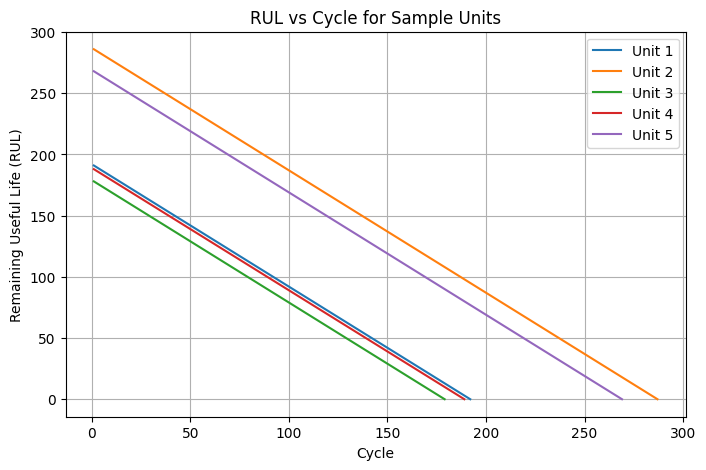

In [4]:
plt.figure(figsize=(8, 5))
for uid in df["unit"].unique()[:5]:  # plot first 5 engines
    subset = df[df["unit"] == uid]
    plt.plot(subset["cycle"], subset["RUL"], label=f"Unit {uid}")
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("RUL vs Cycle for Sample Units")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
label_counts = df["health_stage"].value_counts().reset_index()
label_counts.columns = ["health_stage", "count"]
label_counts["percent"] = (label_counts["count"] / len(df) * 100).round(2)
display(label_counts)


,health_stage,count,percent
0,healthy,8531,41.35
1,warning,7000,33.93
2,near_fail,5100,24.72


In [6]:
out_path = PROC / "train_FD001_labeled.parquet"
df.to_parquet(out_path, index=False)
print("Labeled dataset saved to:", out_path)


Labeled dataset saved to: C:\Users\Admin\Desktop\Projects\turbofan-health-explorer\data\processed\train_FD001_labeled.parquet


In [7]:
print("Label Checks")
print("- RUL decreases monotonically:", df.groupby("unit")["RUL"].apply(lambda x: x.is_monotonic_decreasing).all())
print("- RUL min == 0:", df["RUL"].min() == 0)
print("- Health stages present:", df["health_stage"].unique())
print("- Distribution summary:")
display(df["health_stage"].value_counts(normalize=True).mul(100).round(2))


Label Checks
- RUL decreases monotonically: True
- RUL min == 0: True
- Health stages present: ['healthy' 'warning' 'near_fail']
- Distribution summary:


health_stage
healthy      41.35
warning      33.93
near_fail    24.72
Name: proportion, dtype: float64